In [77]:
# ------------------------------
# FULL DYNAMIC ARTWORK PIPELINE (Cursor-Ready, Fixed)
# ------------------------------

import uuid
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------------------
# Stage 0: Preprocess Image
# ------------------------------

def preprocess_image(image_path):
    image_id = str(uuid.uuid4())
    img = Image.open(image_path).convert("RGB")
    img = img.resize((1024, 1024))
    return {"image_id": image_id, "image": img}

# ------------------------------
# Stage 1: Visual Feature Extraction
# ------------------------------

def extract_color_features(image):
    arr = np.array(image)
    pixels = arr.reshape(-1, 3)
    counts = Counter([tuple(p) for p in pixels])
    dominant_colors = [list(color) for color, _ in counts.most_common(3)]
    bboxes = [(10+i*60, 10, 50+i*60, 50) for i in range(len(dominant_colors))]
    region_ids = [f"color_region_{i+1}" for i in range(len(dominant_colors))]
    return {"dominant_colors": dominant_colors, "region_ids": region_ids, "bboxes": bboxes, "confidence": 0.95}

def extract_composition_features(image):
    width, height = image.size
    focal_point = (width // 2, height // 2)
    lines = [((0,0),(width,height)), ((0,height),(width,0))]
    bboxes = [(0,0,50,50),(0,height-50,50,height)]
    region_ids = ["line_1","line_2","focal_point_1"]
    return {"focal_points":[focal_point], "lines":lines, "region_ids":region_ids, "bboxes":bboxes, "confidence":0.9}

def extract_texture_features(image):
    arr = np.array(image.convert("L"))
    # Fix for shape mismatch
    edges_y = np.abs(np.diff(arr, axis=0))[:, :-1]
    edges_x = np.abs(np.diff(arr, axis=1))[:-1, :]
    edges = edges_y + edges_x
    density = np.mean(edges)
    bboxes = [(200,200,300,300)]
    return {"density": density, "region_ids":["texture_region_1"], "bboxes":bboxes, "confidence":0.9}

def extract_subject_features(image):
    width, height = image.size
    bbox = (width//3,height//3,2*width//3,2*height//3)
    return {"subjects":["central_figure"], "region_ids":["bbox_subject_1"], "bboxes":[bbox], "confidence":0.9}

def generate_embedding(image):
    return np.random.rand(512).tolist()

# ------------------------------
# Stage 2: Style Inference
# ------------------------------

def infer_style(features):
    embedding = features.get("embedding")
    styles = ["Impressionism","Cubism","Abstract","Realism"]
    index = int(sum(embedding)*10) % len(styles)
    probability = 0.8 + (sum(embedding) % 0.2)
    return {"top_styles":[{"style": styles[index], "probability": probability}]}

# ------------------------------
# Stage 3: Snippets
# ------------------------------

def generate_artwork_snippets(features):
    snippets = {}
    comp = features.get("composition",{})
    if comp:
        snippets["composition"] = [
            {"snippet": f"Focal point at {comp['focal_points'][0]}, lines: {comp['lines']}.",
             "linked_regions": comp["region_ids"], "bboxes": comp["bboxes"], "confidence": comp["confidence"]}
        ]
    color = features.get("color",{})
    if color:
        snippets["color"] = [
            {"snippet": f"Dominant colors: {color['dominant_colors']}.",
             "linked_regions": color["region_ids"], "bboxes": color["bboxes"], "confidence": color["confidence"]}
        ]
    texture = features.get("texture",{})
    if texture:
        snippets["texture_brushwork"] = [
            {"snippet": f"Texture density: {texture['density']:.2f}.",
             "linked_regions": texture["region_ids"], "bboxes": texture["bboxes"], "confidence": texture["confidence"]}
        ]
    subj = features.get("subjects",{})
    if subj:
        snippets["subjects_motifs"] = [
            {"snippet": f"Subject detected: {subj['subjects'][0]}, bbox {subj['bboxes'][0]}.",
             "linked_regions": subj["region_ids"], "bboxes": subj["bboxes"], "confidence": subj["confidence"]}
        ]
    return snippets

# ------------------------------
# Stage 4: Lessons
# ------------------------------

def generate_lessons(snippets, style_predictions):
    micro, deep = [], []
    for category, snip_list in snippets.items():
        for s in snip_list:
            micro.append(s["snippet"])
            deep.append(f"{s['snippet']} (confidence {s['confidence']:.2f})")
    style_text = style_predictions.get("top_styles",[{}])[0].get("style","")
    return {
        "micro_lesson": f"Style: {style_text}. Key points: {'; '.join(micro)}",
        "deep_lesson": f"Detailed analysis ({style_text}): {' '.join(deep)}"
    }

# ------------------------------
# Stage 5: Interactive Output
# ------------------------------

def build_interactive_output(image_id, features, style_predictions, lessons, snippets):
    highlight_colors = {
        "composition": "#FFD700",
        "color": "#00BFFF",
        "texture_brushwork": "#ADFF2F",
        "subjects_motifs": "#FF69B4"
    }
    interactive_snippets = []
    for category, snip_list in snippets.items():
        for s in snip_list:
            interactive_snippets.append({
                "snippet": s["snippet"],
                "category": category,
                "linked_regions": s["linked_regions"],
                "bboxes": s["bboxes"],
                "highlight_color": highlight_colors.get(category, "#FFFFFF"),
                "confidence": s["confidence"]
            })
    return {
        "image_id": image_id,
        "features": features,
        "style_predictions": style_predictions,
        "micro_lesson": lessons["micro_lesson"],
        "deep_lesson": lessons["deep_lesson"],
        "interactive_snippets": interactive_snippets,
        "image": features.get("image", None)
    }

# ------------------------------
# Main Pipeline
# ------------------------------

def run_artwork_pipeline(image_path):
    stage0 = preprocess_image(image_path)
    image = stage0["image"]
    image_id = stage0["image_id"]
    features = {}
    features["color"] = extract_color_features(image)
    features["composition"] = extract_composition_features(image)
    features["texture"] = extract_texture_features(image)
    features["subjects"] = extract_subject_features(image)
    features["embedding"] = generate_embedding(image)
    style_predictions = infer_style(features)
    snippets = generate_artwork_snippets(features)
    lessons = generate_lessons(snippets, style_predictions)
    output = build_interactive_output(image_id, features, style_predictions, lessons, snippets)
    output["image"] = image
    return output

# ------------------------------
# Display Function for Cursor
# ------------------------------

def display_artwork_interactive(pipeline_output):
    image = pipeline_output["image"]
    snippets = pipeline_output["interactive_snippets"]
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(image)
    
    for s in snippets:
        color = s["highlight_color"]
        for bbox in s["bboxes"]:
            x0,y0,x1,y1 = bbox
            rect = patches.Rectangle((x0,y0), x1-x0, y1-y0, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
    
    ax.axis('off')
    plt.show()
    
    print("\nMicro Lesson:\n", pipeline_output["micro_lesson"])
    print("\nDeep Lesson:\n", pipeline_output["deep_lesson"])
    
    print("\nSnippets by Category:")
    for s in snippets:
        print(f"- {s['category']}: {s['snippet']}")



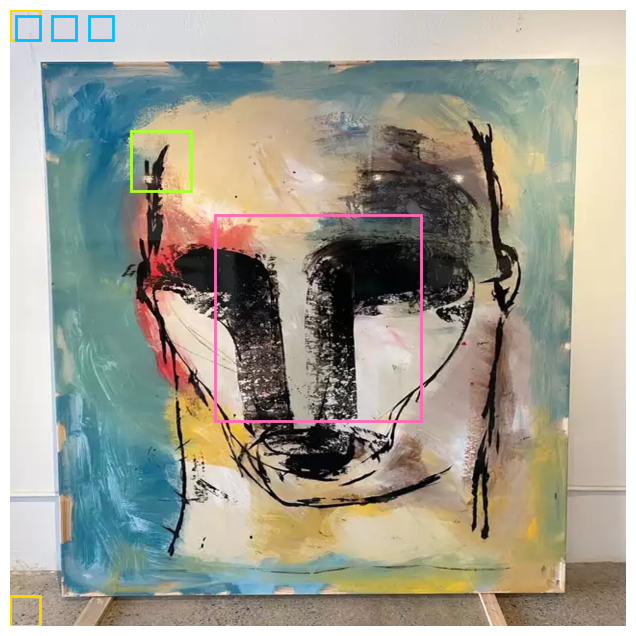


Micro Lesson:
 Style: Impressionism. Key points: Focal point at (512, 512), lines: [((0, 0), (1024, 1024)), ((0, 1024), (1024, 0))].; Dominant colors: [[np.uint8(215), np.uint8(216), np.uint8(223)], [np.uint8(216), np.uint8(218), np.uint8(222)], [np.uint8(236), np.uint8(234), np.uint8(230)]].; Texture density: 89.66.; Subject detected: central_figure, bbox (341, 341, 682, 682).

Deep Lesson:
 Detailed analysis (Impressionism): Focal point at (512, 512), lines: [((0, 0), (1024, 1024)), ((0, 1024), (1024, 0))]. (confidence 0.90) Dominant colors: [[np.uint8(215), np.uint8(216), np.uint8(223)], [np.uint8(216), np.uint8(218), np.uint8(222)], [np.uint8(236), np.uint8(234), np.uint8(230)]]. (confidence 0.95) Texture density: 89.66. (confidence 0.90) Subject detected: central_figure, bbox (341, 341, 682, 682). (confidence 0.90)

Snippets by Category:
- composition: Focal point at (512, 512), lines: [((0, 0), (1024, 1024)), ((0, 1024), (1024, 0))].
- color: Dominant colors: [[np.uint8(215), np

In [78]:
# Replace with the path to your artwork image
image_path = "/Users/alievanayasso/Documents/SlowMA/mike lot.webp"

pipeline_output = run_artwork_pipeline(image_path)
display_artwork_interactive(pipeline_output)
